<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/gdp_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic activity and carbon emissions

This notebook studies the US GDP output and carbon emissions at the quarterly frequency.   
Because the high frequency emission dataset is recent (2019 onwards), the main insight will come from the **Covid-19 event study**. 

## First, quartely GDP data. 

This is the highest frequency at which economic data can be easily obtained.  
The focus in this notebook is on the **United States**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt          # Library for visualization
import seaborn as sns                    # Other package for graphs
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

In [2]:
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GDP&scale=left&cosd=1947-01-01&coed=2021-04-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-09-17&revision_date=2021-09-17&nd=1947-01-01'
data_gdp = pd.read_csv(url)
data_gdp.DATE = pd.to_datetime(data_gdp.DATE)
data_gdp

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
...,...,...
295,2020-10-01,21704.706
296,2021-01-01,22313.850
297,2021-04-01,23046.934


One important precision: each date is associated to its quarter. So January corresponds to the whole Q1 of a given year.  
Let's have a look first.  

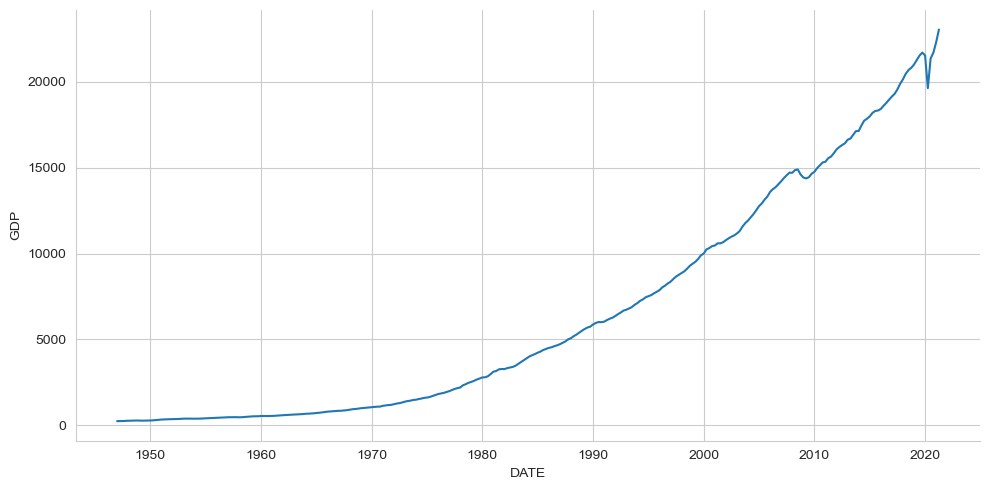

In [3]:
sns.set_style("whitegrid")
sns.relplot(
    data = data_gdp,         # Data source  
    kind = "line",           # Graph type = line
    x = "DATE",              # x-axis = Date column (of course!)
    y = "GDP",               # y-axis = GDP
    aspect = 2
)

Sky is the limit!!!   
**Or is it?**  
This is an essential question for this topic: can we limit our impact on the environment while seeking **infinite growth**?  
Purely mathematically, the answer should be **no**. If natural resources are finite (which they are), then infinite growth is impossible.  
One possible (again, theoretically) counter-argument could be: what if we can progressively increase **productivity** in such a way that we could sustain growth with lower levels of consumption (energy & other resources)?  
Currently, this does not seem feasible. 

## High frequency carbon emissions

Second, we fetch daily (!) emissions from carbonmonitor.  
carbonmonitor.org is an initiative pioneered by researchers that aims to provide near real time emissions across the world and economic sectors.  
The documentation of the methodology is available on the website.

In [4]:
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
# Below, we switch to capital letters for 1st character of column names
data_carbon = data_carbon.rename(columns={'country': 'Country', 
                                          'date': 'Date', 
                                          'sector': 'Sector', 
                                          'value': 'Value', 
                                          'timestamp': 'Timestamp'})
data_carbon['Year'] = data_carbon.Date.dt.year
data_carbon['Quarter'] = data_carbon.Date.dt.quarter
data_carbon

,Country,Date,Sector,Value,Timestamp,Year,Quarter
0,Brazil,2019-01-01,Power,0.096799,1546300800,2019,1
1,China,2019-01-01,Power,14.816100,1546300800,2019,1
2,EU27 & UK,2019-01-01,Power,1.865680,1546300800,2019,1
...,...,...,...,...,...,...,...
132801,UK,2023-04-30,International Aviation,0.095256,1682812800,2023,2
132802,US,2023-04-30,International Aviation,0.203317,1682812800,2023,2
132803,WORLD,2023-04-30,International Aviation,1.604300,1682812800,2023,2


One cool feature is that emissions are broken down by sectors.

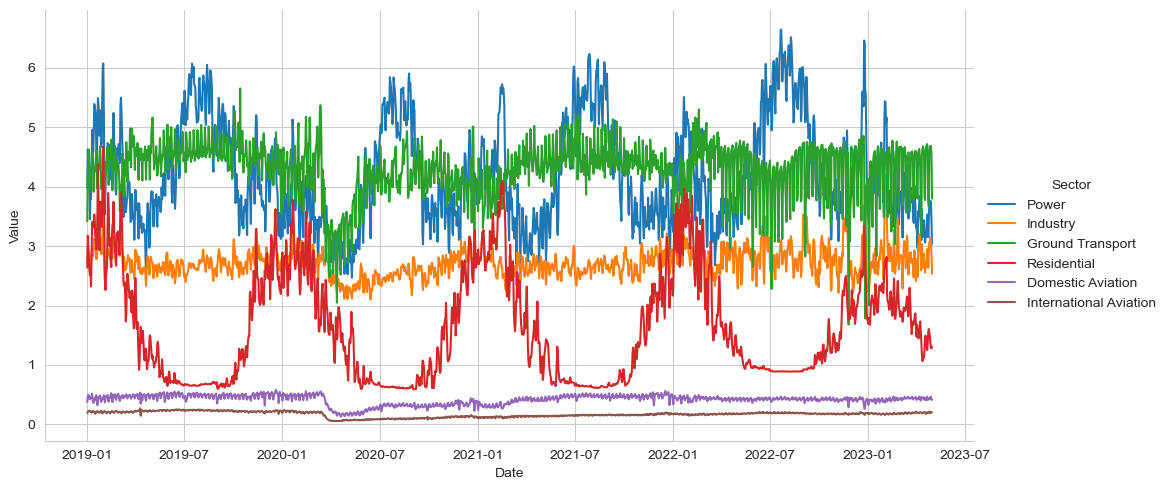

In [5]:
sns.set_style("whitegrid")
sns.relplot(
    data = data_carbon.query("Country == 'US'"),   # Data source  
    kind = "line",                                 # Graph type = line
    x = "Date",                                    # x-axis = Date column (of course!)
    y = "Value",                                   # y-axis = emission values
    hue = "Sector",                                # Color = sector
    aspect = 2
)

Some curves are quite constant through time (industry, ground transport except for the Covid depression), but some are very cyclical!  
For instance, residential emissions are lower during the summer, while it is the opposite for power (is there a transfer between heating & air conditioning?).  
Aviation seems marginal.  

We aim to look at simple series. We need to:
- restrict the data to the US;  
- aggregate all sources of emissions (sectors) via a pivot table;  
- keep only quarterly points (first days of January, April, July and October) - this is automatic via joining.

In [6]:
data_carbon_q = data_carbon.query('Country == "US"').pivot_table(values = ['Value'], 
                                                 aggfunc = 'sum', 
                                                 index = ['Country', 'Year', 'Quarter']).reset_index()
data_carbon_q['Month'] = data_carbon_q['Quarter']*3 - 2
data_carbon_q['Day'] = 1
data_carbon_q['Date'] = pd.to_datetime(data_carbon_q[['Year', 'Month', 'Day']])
data_carbon_q

,Country,Year,Quarter,Value,Month,Day,Date
0,US,2019,1,1369.934514,1,1,2019-01-01
1,US,2019,2,1171.569368,4,1,2019-04-01
2,US,2019,3,1279.821362,7,1,2019-07-01
...,...,...,...,...,...,...,...
15,US,2022,4,1249.639558,10,1,2022-10-01
16,US,2023,1,1229.806992,1,1,2023-01-01
17,US,2023,2,377.806059,4,1,2023-04-01


In the pivot table, the values are those for the whole quarter that **succedes** to the Date column.   
This is an important point to keep in mind.   
We can now join the two sets.

In [7]:
data_merged = pd.merge(data_carbon_q,
                       data_gdp, 
                       left_on='Date', 
                       right_on='DATE')
data_merged

,Country,Year,Quarter,Value,Month,Day,Date,DATE,GDP
0,US,2019,1,1369.934514,1,1,2019-01-01,2019-01-01,21013.085
1,US,2019,2,1171.569368,4,1,2019-04-01,2019-04-01,21272.448
2,US,2019,3,1279.821362,7,1,2019-07-01,2019-07-01,21531.839
...,...,...,...,...,...,...,...,...,...
7,US,2020,4,1192.392460,10,1,2020-10-01,2020-10-01,21704.706
8,US,2021,1,1265.012147,1,1,2021-01-01,2021-01-01,22313.850
9,US,2021,2,1151.251126,4,1,2021-04-01,2021-04-01,23046.934


And then plot!


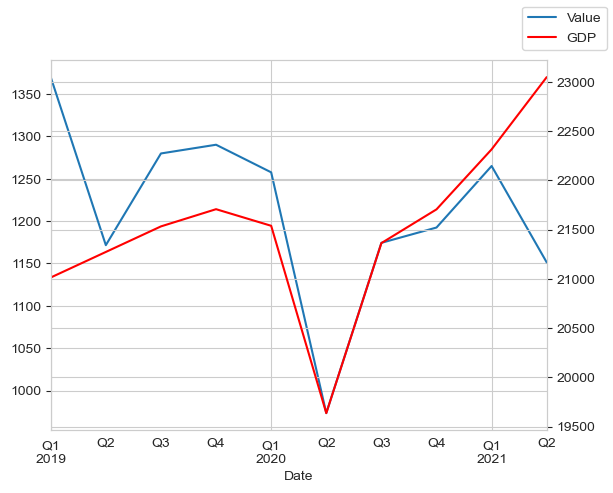

In [8]:
ax = data_merged.plot(x = "Date", y = "Value", legend = False)
ax2 = ax.twinx()
data_merged.plot(x = "Date", y = "GDP", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.rcParams["figure.figsize"]=(16, 10)
plt.show()

The correspondence is not perfect, though the most important movements coincide, especially the *COVID* quarter of 2020 when the US was hit the hardest - at least economically. 

Let's take a step back & see the sector breakdown.

In [9]:
data_q_sect = data_carbon.query('Country == "US"').pivot_table(values = ['Value'], 
                                                 aggfunc = 'sum', 
                                                 index = ['Country', 'Year', 'Quarter', 'Sector']).reset_index()
data_q_sect['Month'] = data_q_sect['Quarter']*3 - 2
data_q_sect['Day'] = 1
data_q_sect['Date'] = pd.to_datetime(data_q_sect[['Year', 'Month', 'Day']])     
data_q_sect= pd.merge(data_q_sect,
                       data_gdp, 
                       left_on='Date', 
                       right_on='DATE')                                           

Once the new dataframe is aggregated, we plot the curves.

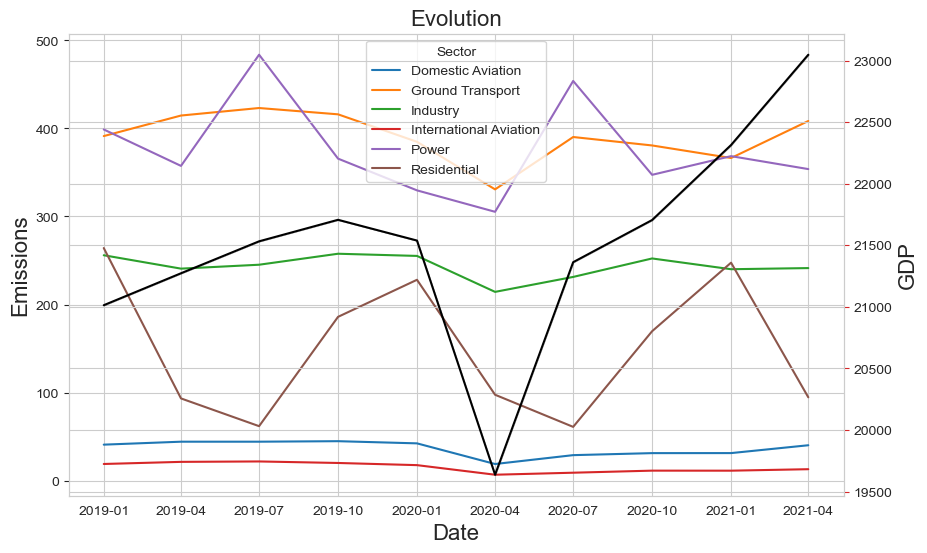

In [10]:
fig, ax1 = plt.subplots(figsize = (10,6))
color = 'tab:green'
ax1.set_title('Evolution', fontsize = 16)
ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylabel('Emissions', fontsize = 16)
ax1 = sns.lineplot(
    data = data_q_sect,   # Data source  
    x = "Date",           # x-axis = Date column (of course!)
    y = "Value",          # y-axis = emission values
    hue = "Sector"        # Color = sector
)

ax1.tick_params(axis = 'y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('GDP', fontsize = 16)
ax2 = sns.lineplot(
    data = data_q_sect,   # Data source  
    x = "Date",           # x-axis = Date column (of course!)
    y = "GDP",            # y-axis = emission value
    color = "black"
)
ax2.tick_params(axis='y', color=color)
plt.show()

The big dive came from **ground transport**, **residential** mostly + **power** and **industry** to a certain degree.

# Conclusion

While again we cannot pretend to have revealed **causation** (economic activity => emissions), the Covid-19 episode provides an insightful event study that shows that reduced human activities were undoubtfully linked to lower emissions.   
Overall, this seems pretty obvious...